# Import packages

In [1]:
import warnings
import numpy as np
import pandas as pd
import os
import glob
import shutil
from tqdm import tqdm
from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker, colors, dates
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
import seaborn as sns

from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import time as dtime

import torchvision
import torch
from torchvision import transforms

from utils import get_instance_segmentation_model
from utils import psd2im, draw_subplots, reshape_mask, mkdirs
from utils import get_SE, get_GR, get_GR_old, convert_matlab_time

import string

font = {'family': 'Arial'}
matplotlib.rc('font', **font)
%matplotlib inline 

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2


In [2]:
# check the font family
matplotlib.rcParams['font.family']

['Arial']

# Help functions

In [3]:
def bnd2cnt(x):
    """xyxy to cxcywh"""
    x0, y0, x1, y1 = x.unbind(-1)

    w = x1 - x0
    h = y1 - y0
    return x0.item(), y0.item(), w.item(), h.item()

def draw_mask(mask, box, score, savefp=None):
    """Draw a single mask with bounding box and score."""
    fig, ax = plt.subplots()

    # show mask
    ax.imshow(mask, cmap='gray')

    # draw bounding box
    x, y, w, h = bnd2cnt(box)
    rect = plt.Rectangle((x, y), w, h, fill=False,
                         edgecolor='red', linewidth=3)
    ax.add_patch(rect)
    ax.text(x*(1-0.2), y*(1-0.05), 'event:\n {:.2f}'.format(
        score), fontsize=20, color='yellow', fontweight='bold')
    plt.axis('off')
    if savefp is not None:
        fig.savefig(savefp, dpi=600, bbox_inches='tight', pad_inches=0)

@torch.no_grad()
def draw_masks(fp, name, savefp=None, model=None):
    im = Image.open(os.path.join(fp, name+'.png')
                    ).convert('RGB').resize((256, 256), Image.ANTIALIAS)
    ts = transforms.ToTensor()(im)
    out = model([ts.cuda()])[0]
    if savefp is not None:
        mkdirs(savefp)
        for i in range(len(out['scores'])):
            draw_mask(out['masks'][i, 0].detach().cpu().numpy(), out['boxes'][i],
                      out['scores'][i].item(), savefp=f'{savefp}/{name}_mask_{i}.png')
    else:
        return out['masks']

def check_with_labels(days, label_df):
    labels = label_df[label_df.time.isin(days)].loc[:, 'class'].values

    label, counts = np.unique(labels, return_counts=True)
    print('-'*40)
    print(f'Total detected days: {labels.shape[0]}')
    for i in range(len(label)):
        print(f'For class {label[i]}, there are {counts[i]} detected days.')

def get_score_for_days(preds, thres):
    valid_scores = []
    for item in tqdm(preds):
        score = item['scores']
        if sum(score >= thres) > 0:
            valid_scores.append(item['day'])
    return valid_scores


# Load the Mask R-CNN model

In [4]:
model = get_instance_segmentation_model()
modelfp = 'checkpoints/maskrcnn.pth'
model.load_state_dict(torch.load(modelfp))
model.cuda()
model.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

# Draw event types (Fig. 2)

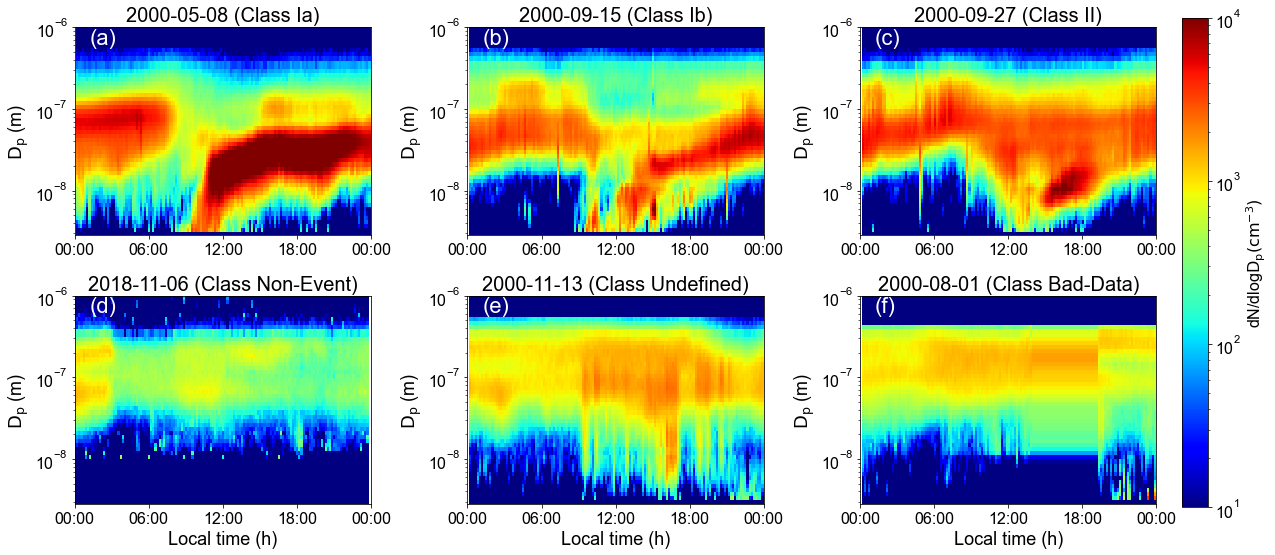

In [5]:
plt.rcParams.update({'font.size': 16})

savefp = 'figures'
mkdirs(savefp)
savename = 'NPF-event_types'
df = pd.read_csv('datasets/hyytiala/hyytiala_events.csv',
                 parse_dates=[0], index_col=0)
names = ['2000-05-08', '2000-09-15', '2000-09-27',
         '2018-11-06', '2000-11-13', '2000-08-01']
indexes = ['(Class Ia)', '(Class Ib)', '(Class II)',
           '(Class Non-Event)', '(Class Undefined)', '(Class Bad-Data)']
texts = np.array(
    [letter for letter in string.ascii_lowercase[:6]]).reshape(2, 3)
draw_subplots(df, names, nrows=2, ncols=3, use_title=True, indexes=indexes,
              savefp=savefp, savename=savename, texts=texts, ftsize=16)

# Model architecture (Fig. 3)

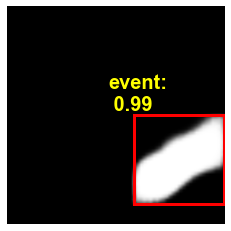

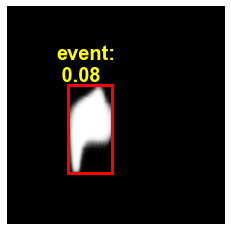

In [6]:
draw_masks('datasets/img', name='2000-03-27', savefp='figures', model=model)

# Flowchart (Fig. 4)

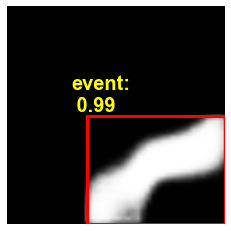

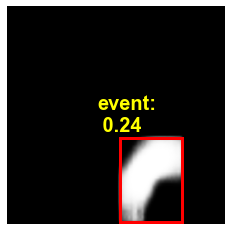

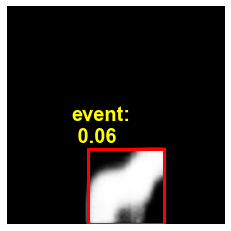

In [7]:
draw_masks('datasets/img', name='2013-04-03', savefp='figures', model=model)

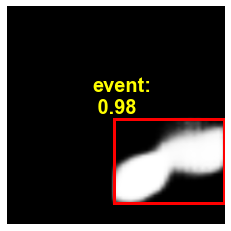

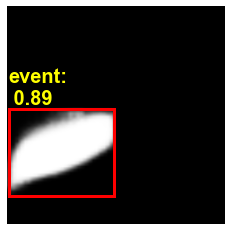

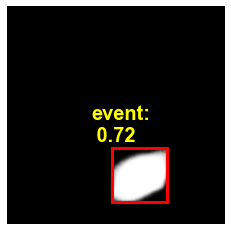

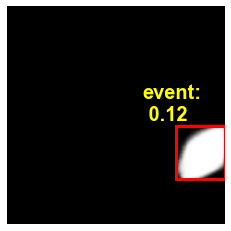

In [8]:
draw_masks('datasets/img', name='2015-03-27', savefp='figures', model=model)

# Align NPF image with data (Fig. 5) 

(144, 52)


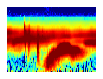

In [9]:
name = '2018-05-10'
df = pd.read_csv('datasets/align.csv', parse_dates=[0], index_col=0)
psd2im(df[name], savefp=r'datasets/img', use_xaxis=False, use_yaxis=False)
print(df.shape)

(-0.5, 51.5, 143.5, -0.5)

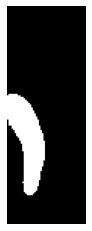

In [10]:
mask = draw_masks('datasets/img', name, model=model).squeeze().cpu().numpy() >= 0.50
aligned_mask = reshape_mask(mask, df.shape)
plt.imshow(aligned_mask, cmap='gray')
plt.axis('off')

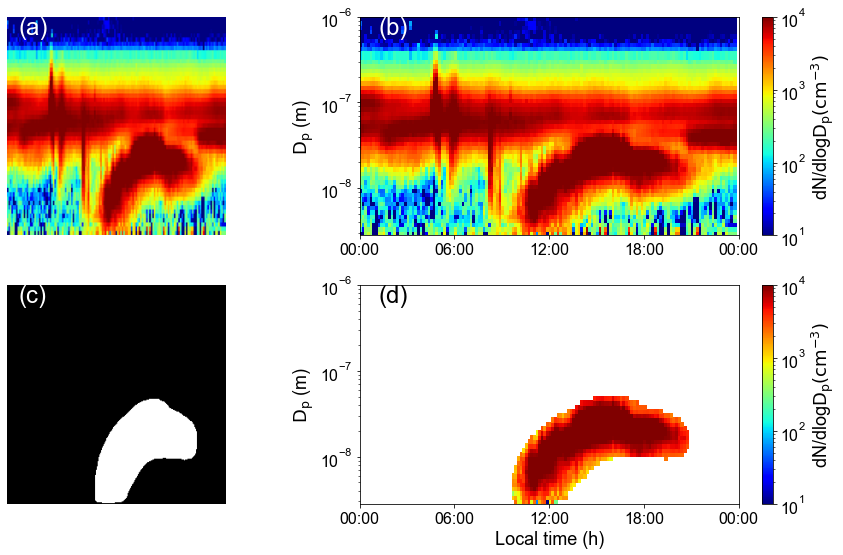

In [11]:
# draw all the maps together
plt.rcParams.update({'font.size': 16})
ftsize = 18
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
im = Image.open(
    f'datasets/img/{name}.png').convert('RGB').resize((256, 256), Image.ANTIALIAS)
axes[0, 0].imshow(im)
axes[0, 0].axis('off')

psd2im(df[name], ax=axes[0, 1], mask=None, use_cbar=True, vmax=1e4, fig=fig)

axes[1, 0].imshow(mask >= 0.50, cmap='gray')
axes[1, 0].axis('off')

psd2im(df[name], ax=axes[1, 1], mask=aligned_mask,
       use_cbar=True, vmax=1e4, fig=fig, use_xlabel=True)

texts = np.array(
    [letter for letter in string.ascii_lowercase[:4]]).reshape(2, 2)
colors = np.array(['white']*3+['k']).reshape(2, 2)

for i in range(2):
    for j in range(2):
        axes[i, j].text(0.05, 0.92, f'({texts[i, j]})', transform=axes[i,
                        j].transAxes, fontsize=ftsize+6, color=colors[i, j])

fig.tight_layout()
fig.savefig('figures/aligned_psd.png', dpi=600,
            bbox_inches='tight', pad_inches=0.1)
fig.savefig('figures/aligned_psd.pdf', bbox_inches='tight', pad_inches=0.1)


# Determine the GRs (Fig. 6)

In [5]:
def vis_GR(df, name, index, vmax, savefp='figures'):
    mask = reshape_mask(draw_masks('datasets/img', name, model=model)
                        [index, 0].detach().cpu().numpy() >= 0.50, df[name].shape)
    _, x_pred, y_pred = get_GR_old(
        df[name], mask, 2.72, 25.2, savefp=savefp, tm_res=10, vmax=vmax)
    return [x_pred, y_pred*1e-9]


In [6]:
dfs, names, GRs = [], [], []


## $\mathrm{V\ddot{a}rri\ddot{o}}$

(4, 4, 4)

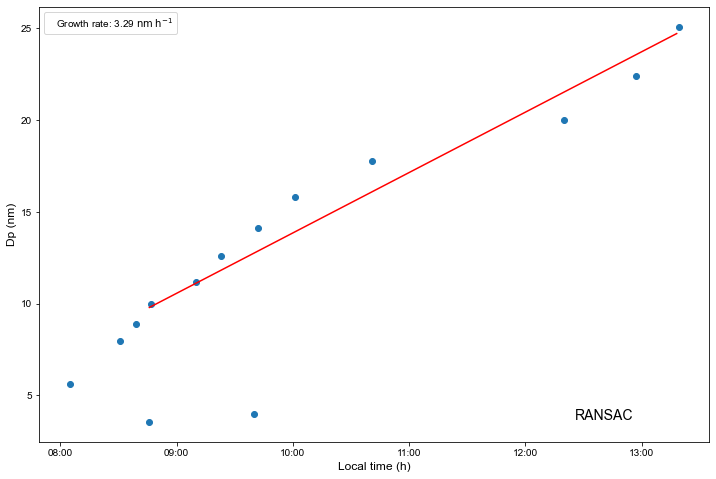

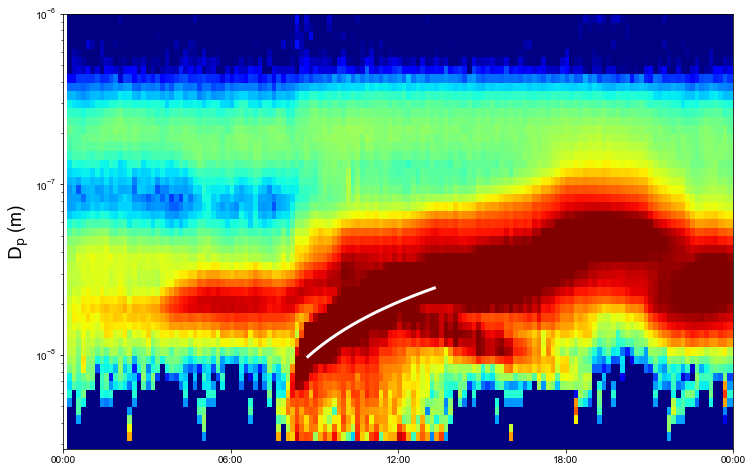

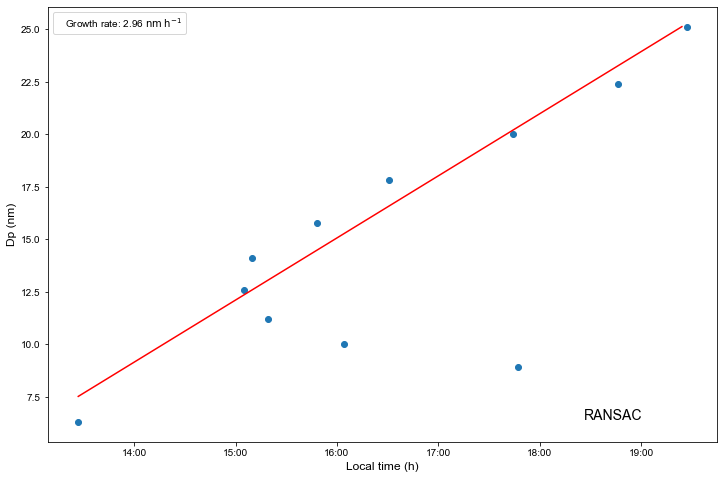

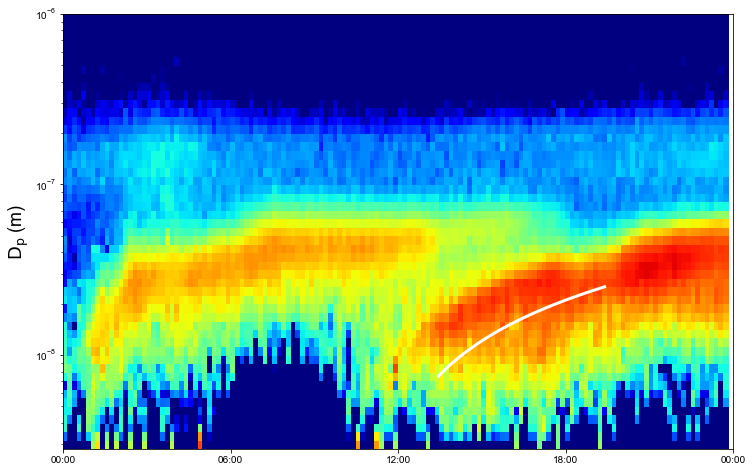

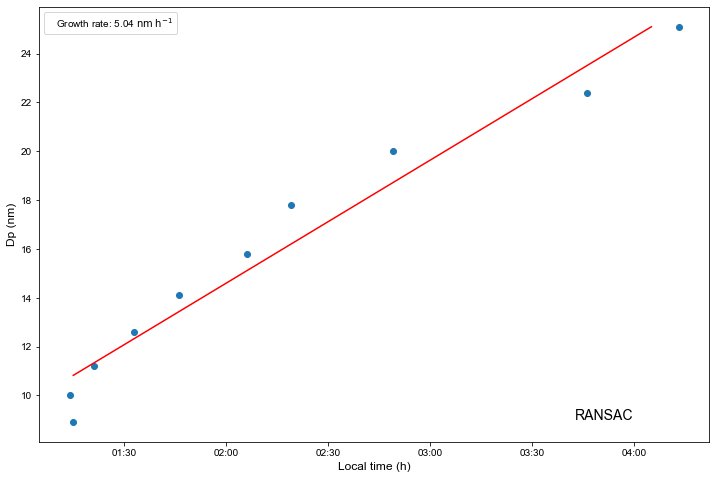

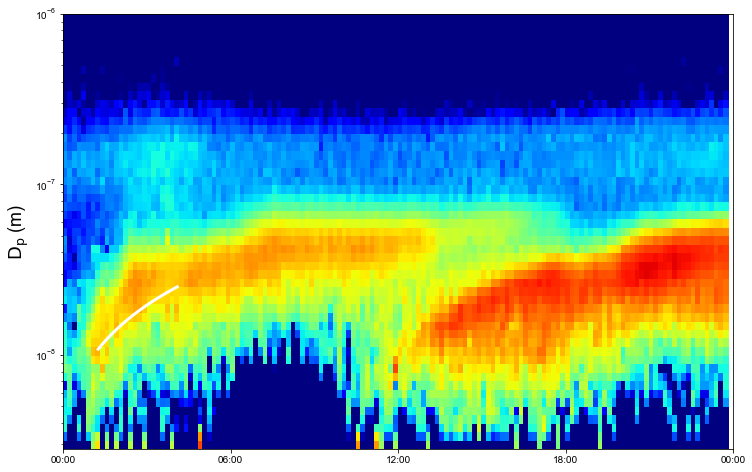

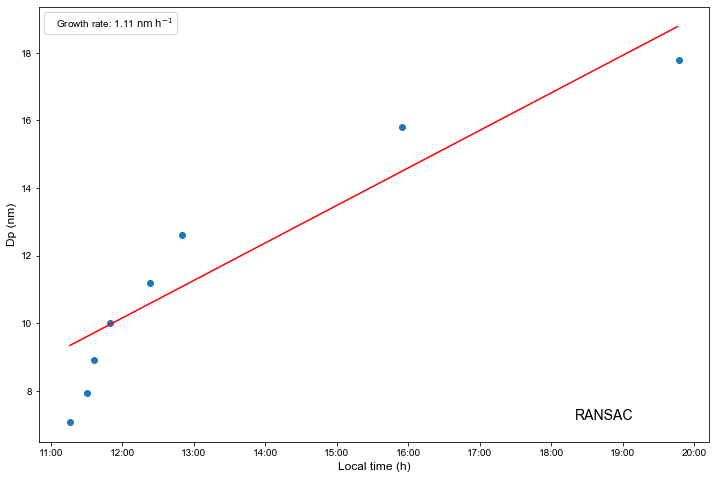

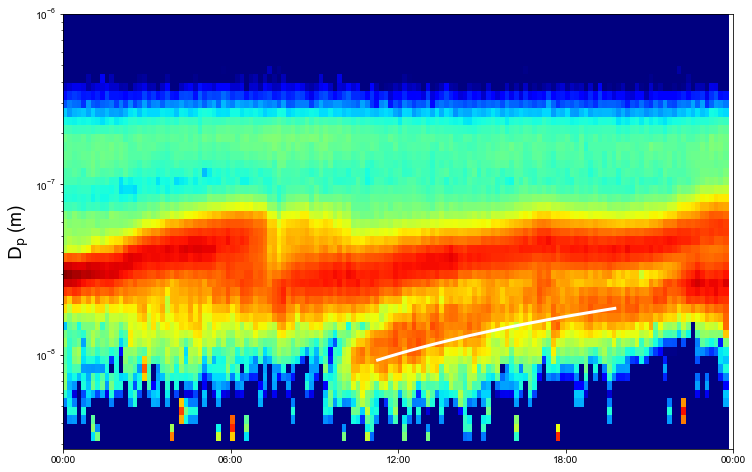

In [7]:
df = pd.read_csv('datasets/varrio_gr.csv', parse_dates=[0], index_col=0)

names_ = ['2005-04-29', '2015-10-28', '2015-10-28', '2017-05-21']
for idx, name in enumerate(names_):
    dfs.append(df.loc[name])
    names.append(name)
    if idx == 2:
        GRs.append(vis_GR(df.loc[name], name, 1, 1e4))
    else:
        GRs.append(vis_GR(df.loc[name], name, 0, 1e4))
len(GRs), len(dfs), len(names)

## $\mathrm{Hyyti\ddot{a}l\ddot{a}}$

(8, 8, 8)

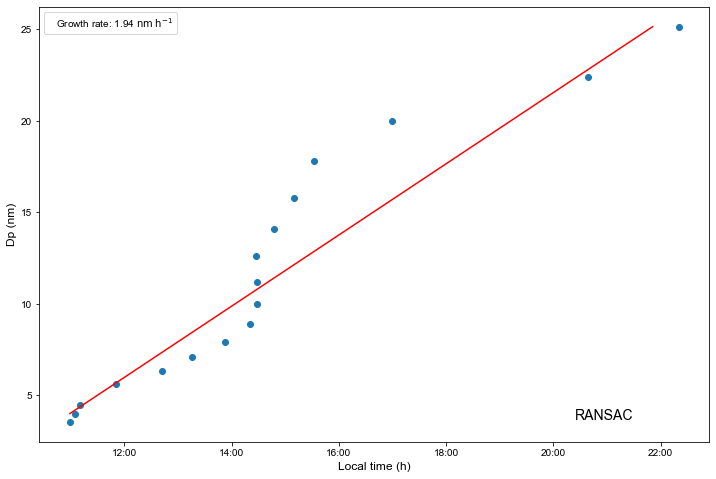

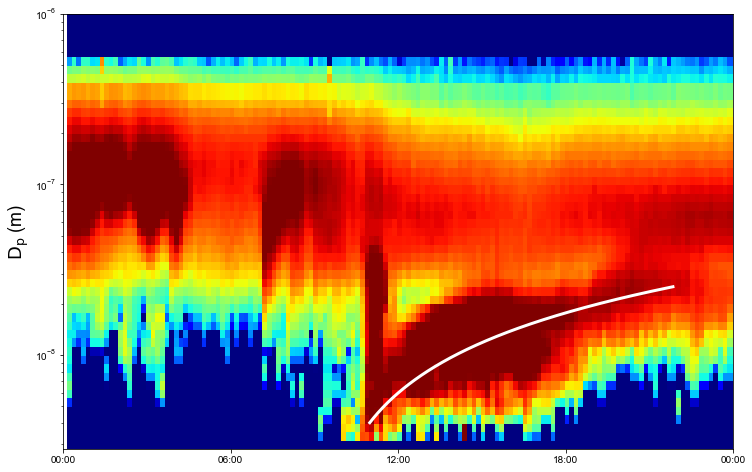

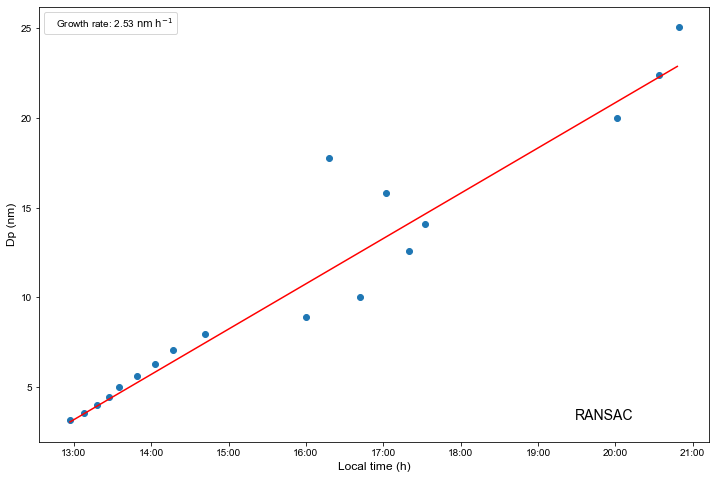

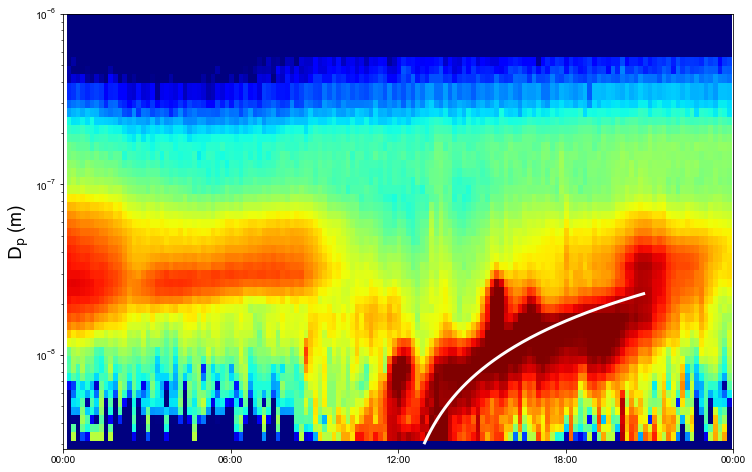

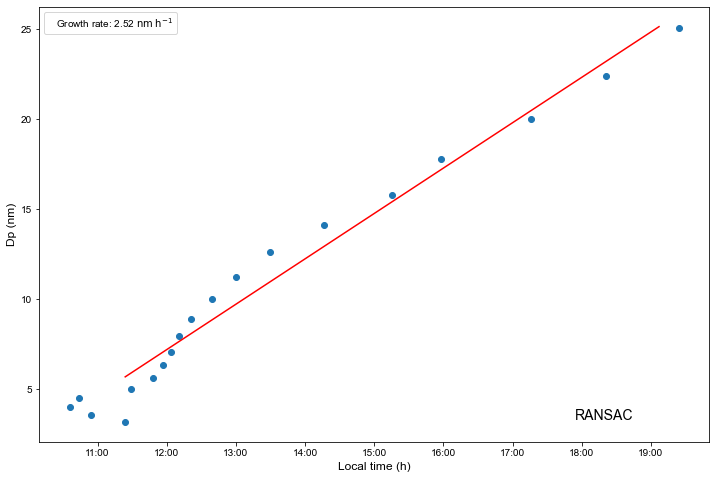

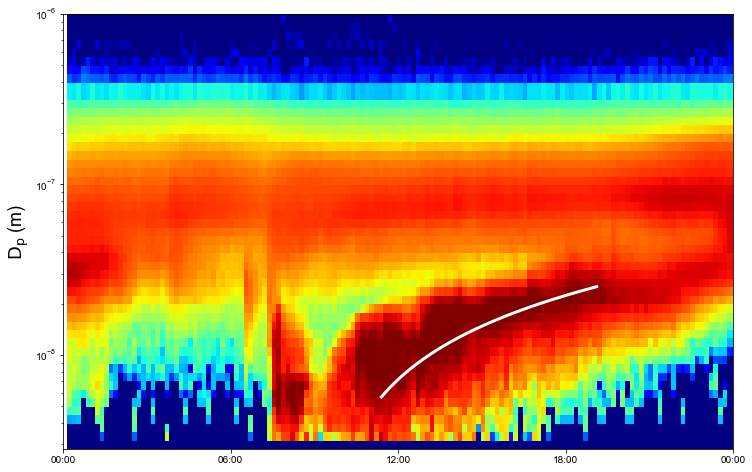

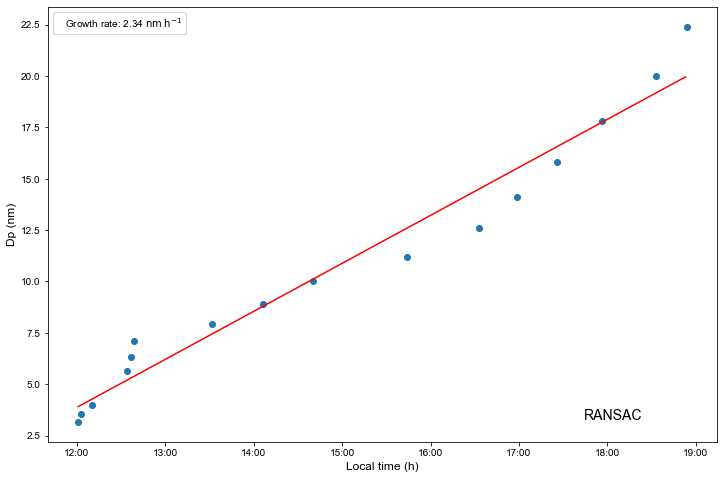

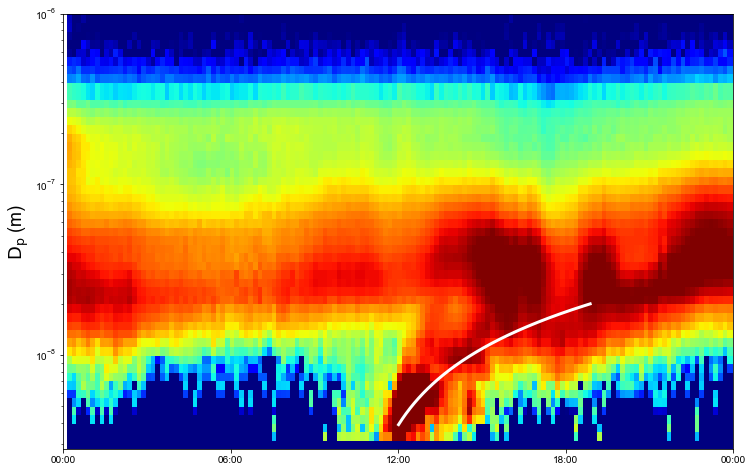

In [8]:
df = pd.read_csv('datasets/hyytiala_gr.csv', parse_dates=[0], index_col=0)
names_ = ['1996-03-24', '2003-03-15', '2005-05-21', '2006-03-13']
for name in names_:
    dfs.append(df[name])
    names.append(name)
    GRs.append(vis_GR(df[name], name, 0, 1e4))
len(GRs), len(dfs), len(names)


## Kumpula

(12, 12, 12)

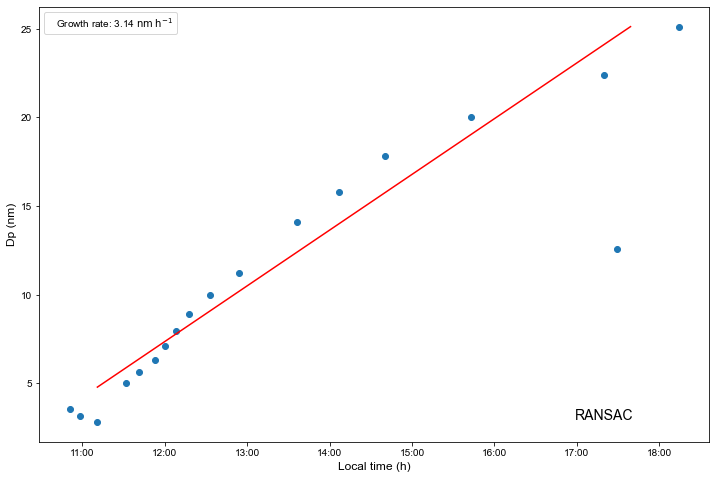

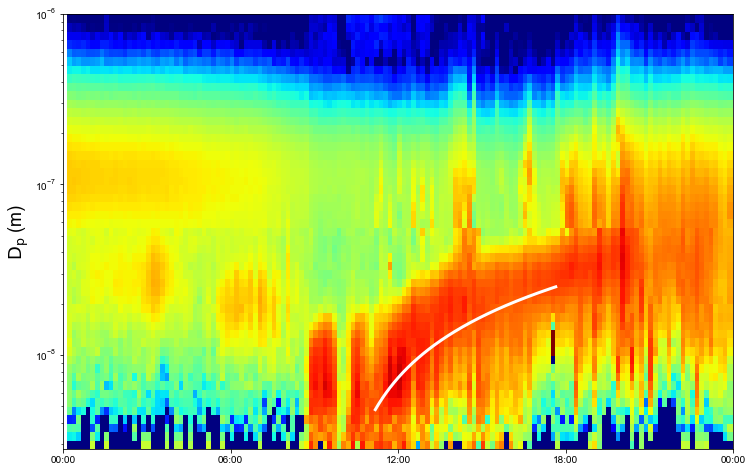

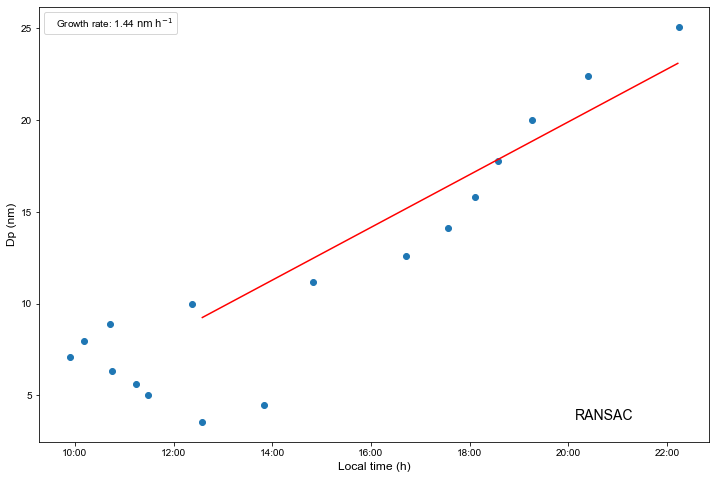

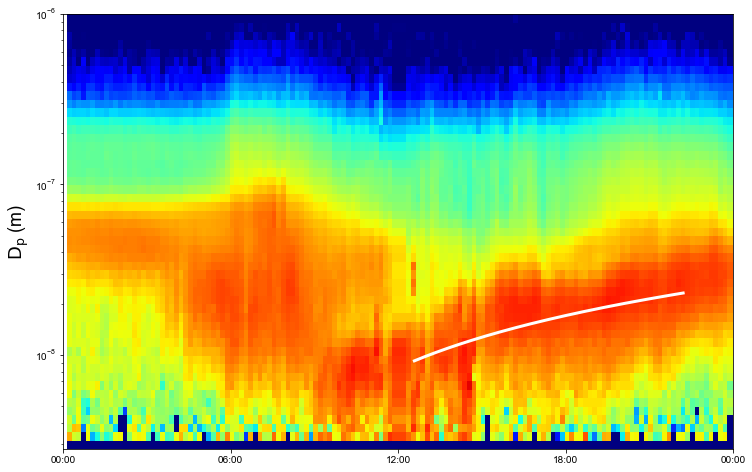

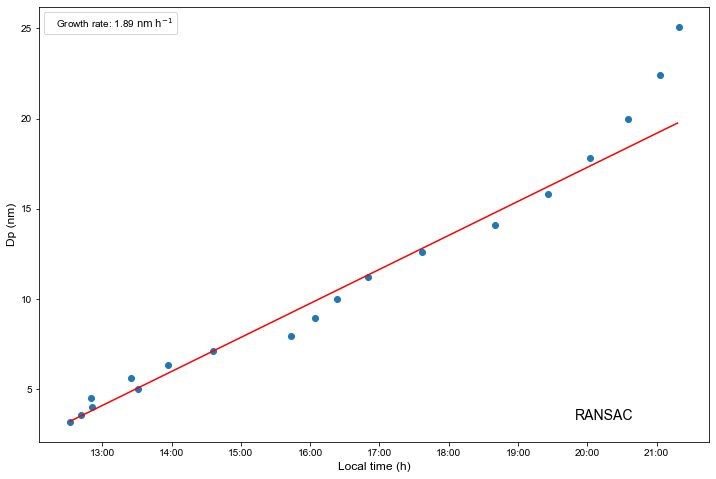

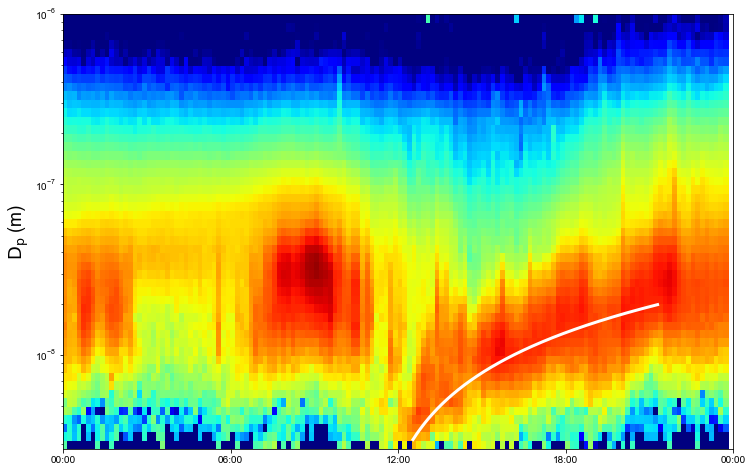

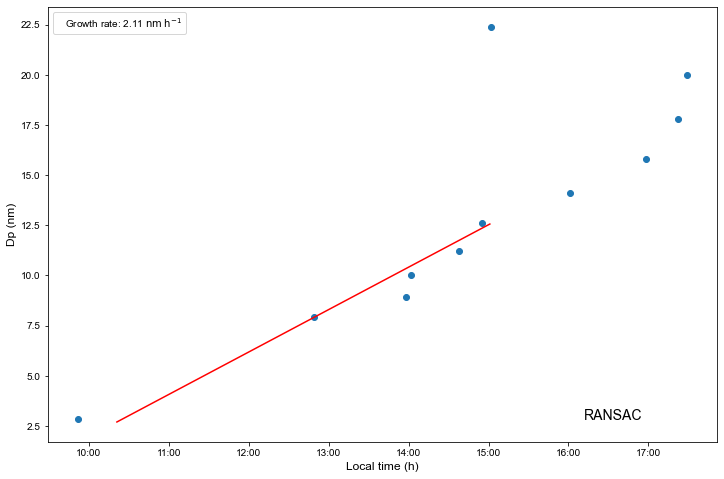

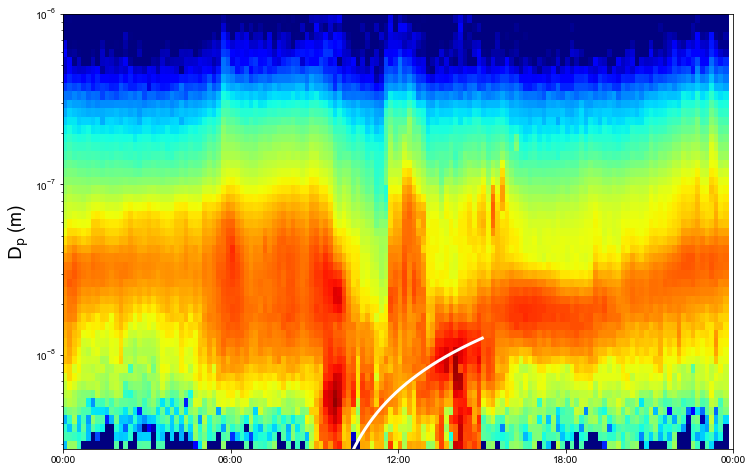

In [9]:
df = pd.read_csv('datasets/kumpula_gr.csv', parse_dates=[0], index_col=0)
names_ = ['2005-04-03', '2005-09-16', '2013-03-26', '2013-04-03']
for name in names_:
    dfs.append(df[name])
    names.append(name)
    GRs.append(vis_GR(df[name], name, 0, 1e5))
len(GRs), len(dfs), len(names)

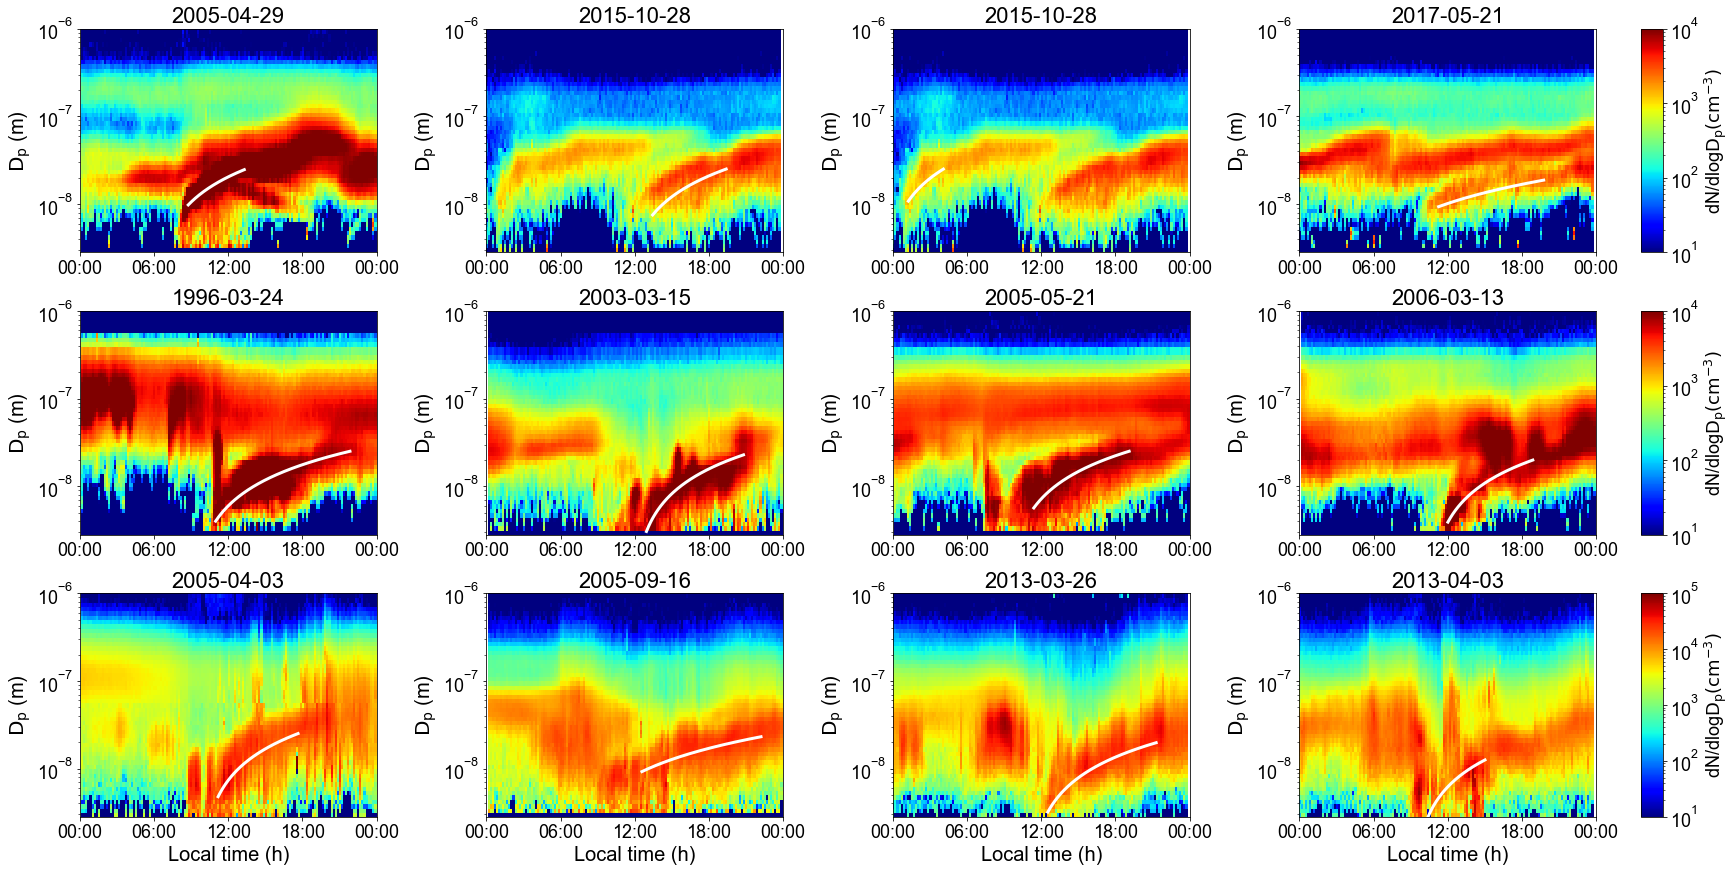

In [10]:
ftsize = 18
plt.rcParams.update({'font.size': ftsize})

savefp = 'figures'
savename = 'NPF-GR_vis'
draw_subplots(dfs, names, nrows=3, ncols=4,
              GRs=GRs, use_title=True, vmaxs=[1e4, 1e4, 1e5],
              savefp=savefp, savename=savename, cbar='multirow',
              ftsize=ftsize)